# Data analysis for the Ultimate Refriz Frames Project
(To see associated experimental stimuli script, [go here](https://bitbucket.org/smweis/frizrf/overview)
We import the necessary modules, and one custom function that wraps up data importing.

This creates three datasets: 

**data** -> Data from all trials.

**all_answers_data** -> No High RTs

**unthreshed_data** -> no High RTs, no incorrect answers.

**dataForPlot** -> Set in Cell 2 - the data that will be displayed. 

In [31]:
#Load and clean data.

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy
import statsmodels.api as sm
#import statsmodels.formula.api as smf

#custom function
from importData import getData

#Get Data
frizData = getData('C:\\Users\\stweis\\Dropbox\\Penn Post Doc\\Frisbee_Ref_Frames\\data\\batch1\\friz_clean')
navData = getData('C:\\Users\\stweis\\Dropbox\\Penn Post Doc\\Frisbee_Ref_Frames\\data\\batch1\\nav_clean')
additionalData = pd.read_excel('C:\\Users\\stweis\\Dropbox\\Penn Post Doc\\Frisbee_Ref_Frames\\data\\batch1\\additionalData_For_Python.xlsx',header=0)
#Recode "psychopycode to participant"
additionalData['participant'] = additionalData['psychopycode']

#Clean data functions
def removeHighRTs(howManySDs,dv,data):
    rtThresh = howManySDs*np.std(data[dv])
    rtMean = np.mean(data[dv])
    dataThresh = data.loc[data[dv] < (rtMean + rtThresh)]
    dataThresh = dataThresh.loc[dataThresh[dv] > 0]
    return dataThresh


def removeWrongAnswers(dv,data):
    dataCorrect = data.loc[data[dv] == 1]
    return dataCorrect


def renameFactorLevels(data,friz_or_nav):
    data['condition'] = friz_or_nav
    prompts = sorted(data.prompt1.unique())
    stims = sorted(data.stim1.unique())
    new_stims = ['far_left','far_right','near_left','near_right']

    if friz_or_nav == 'friz':    
        new_prompts = ['Away','Left','Right','Home']
    else:
        new_prompts = ['Away','Home','Left','Right']
        
    for i in range(len(prompts)):
        data = data.replace(prompts[i],new_prompts[i])
        data = data.replace(stims[i],new_stims[i])
        
    return data


def newFactorPrompts(row):
    if row['prompt1'] == 'Home' or row['prompt1'] == 'Away':
        return 'Absolute'
    else:
        return 'Relative'

    
def newFactorStims(row):
    if row['stim1'] == 'near_right' or row['stim1'] == 'near_left':
        return 'Near'
    else:
        return 'Far'
    

#Rename conditions
frizData = renameFactorLevels(frizData,'Frisbee')
navData = renameFactorLevels(navData,'Navigation')
#Recode stimulus location to a binary variable.
frizData['stimLoc'] = frizData.apply(lambda row: newFactorStims(row),axis=1)
navData['stimLoc'] = navData.apply(lambda row: newFactorStims(row),axis=1)
#Recode prompt type to a binary variable. 
frizData['promptType'] = frizData.apply(lambda row: newFactorPrompts(row),axis=1)
navData['promptType'] = navData.apply(lambda row: newFactorPrompts(row),axis=1)

#Threshold data at 2 RT's above mean.
frizDataThresh = removeHighRTs(2, 'Trials_responsert',frizData)
navDataThresh = removeHighRTs(2, 'Trials_responsert',navData)


all_answers_data = frizDataThresh.append(navDataThresh)


data = removeWrongAnswers('Trials_responsecorr',all_answers_data)

unthreshed_data = frizData.append(navData)

neccessaryAdditionalData = additionalData.loc[:,
                                              ["Sex","participant",
                                               "SBSOD_AVERAGE",
                                               "Friz_Total_Years_Played",
                                               "Friz_Force_Preference",
                                               "Friz_Position"]]



In [32]:
def chooseYourData():

    strData = input("data=1, all_answers_data=2, unthreshed_data=3: ")
    whichData = int(strData)
    if whichData == 1:
        dataForPlot = data
    elif whichData == 2:
        dataForPlot = all_answers_data
    elif whichData == 3:
        unthreshed = unthreshed_data
    else:
        chooseYourData()

    return dataForPlot

dataForPlot = chooseYourData()

data=1, all_answers_data=2, unthreshed_data=3: 2


In [33]:
#Pivot and recode data.

pivoted = dataForPlot.pivot_table(index='participant',columns=['condition','stimLoc','promptType'],
                                  values='Trials_responsert',aggfunc=np.mean)

#pivoted.isnull().sum() #To see how many cells have no data. 
pivoted = pivoted.dropna() #otherwise this won't work - so some data is missing

pivoted['Frisbee_Rel_minus_Abs_Far'] = pivoted['Frisbee']['Far']['Relative'] - pivoted['Frisbee']['Far']['Absolute']
pivoted['Frisbee_Rel_minus_Abs_Near'] = pivoted['Frisbee']['Near']['Relative'] - pivoted['Frisbee']['Near']['Absolute']
pivoted['Frisbee_Rel_minus_Abs'] = (pivoted['Frisbee_Rel_minus_Abs_Far'] + pivoted['Frisbee_Rel_minus_Abs_Near'])/2
pivoted['Nav_Rel_minus_Abs_Far'] = pivoted['Navigation']['Far']['Relative'] - pivoted['Navigation']['Far']['Absolute']
pivoted['Nav_Rel_minus_Abs_Near'] = pivoted['Navigation']['Near']['Relative'] - pivoted['Navigation']['Near']['Absolute']
pivoted['Nav_Rel_minus_Abs'] = (pivoted['Nav_Rel_minus_Abs_Far'] + pivoted['Nav_Rel_minus_Abs_Near'])/2

pivotedAllFour = dataForPlot.pivot_table(index='participant',columns=['condition','prompt1'],values='Trials_responsert',aggfunc=np.mean)
pivotedAllFour['Friz_Back_minus_Fore'] = pivotedAllFour['Frisbee']['Left'] - pivotedAllFour['Frisbee']['Right']
pivotedAllFour['Friz_Home_minus_Away'] = pivotedAllFour['Frisbee']['Home'] - pivotedAllFour['Frisbee']['Away']
pivotedAllFour['Nav_Left_minus_Right'] = pivotedAllFour['Navigation']['Left'] - pivotedAllFour['Navigation']['Right']
pivotedAllFour['Nav_Home_minus_Away'] = pivotedAllFour['Navigation']['Home'] - pivotedAllFour['Navigation']['Away']
pivoted.sort_index(inplace=True)
pivotedAllFour.sort_index(inplace=True)

# Merges pivoted data with additional data (columns from necessaryAdditionalData)
grandmean = dataForPlot.pivot_table(index='participant',columns=['condition'],values='Trials_responsert',aggfunc=np.mean)
pivoted['participant'] = pivoted.index
pivoted[['participant']] = pivoted[['participant']].apply(pd.to_numeric)
neccessaryAdditionalData.sort_values('participant',inplace=True)
pivoted.sort_values('participant',inplace=True)
merged = pivoted.merge(neccessaryAdditionalData,on='participant')
grandmean['participant'] = grandmean.index
grandmean[['participant']] = grandmean[['participant']].apply(pd.to_numeric)

merged = merged.merge(grandmean,on='participant')






C:\Users\stweis\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:558: UserWarning: merging between different levels can give an unintended result (3 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


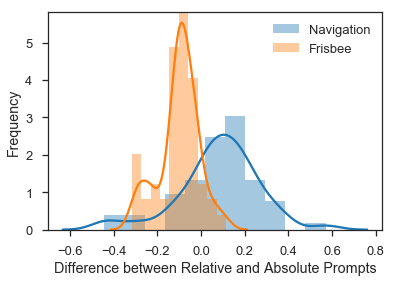

In [34]:
# Compare frisbee and navigation reaction times.

ax1 = sns.distplot(nonaPivoted['Nav_Rel_minus_Abs'],label='Navigation')
sns.distplot(nonaPivoted['Frisbee_Rel_minus_Abs'],label='Frisbee')
ax1.set(xlabel='Difference between Relative and Absolute Prompts',ylabel='Frequency')
plt.legend()
plt.show()


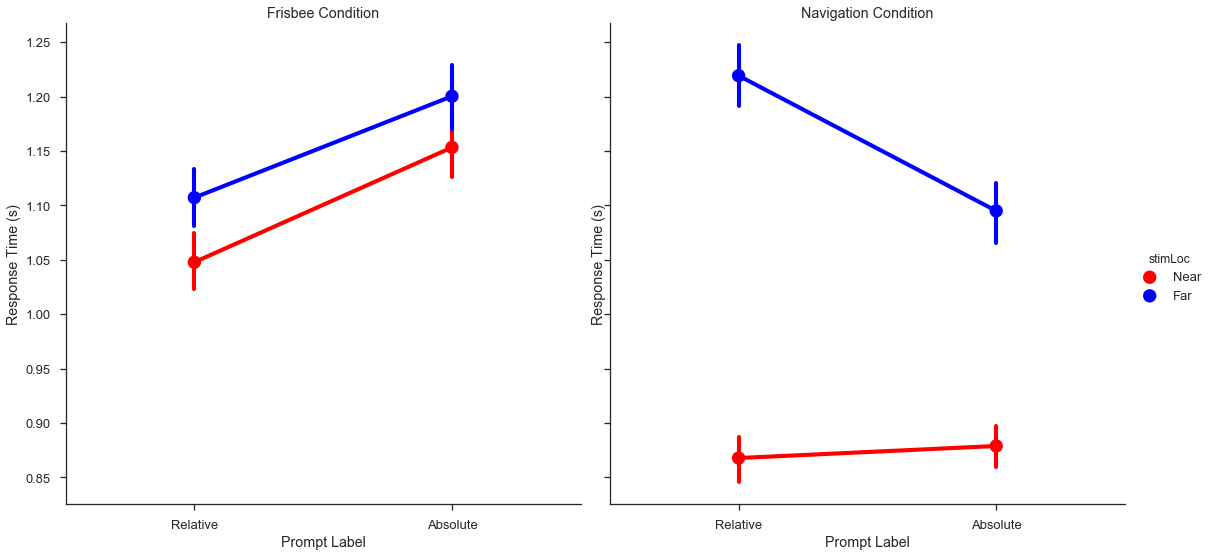

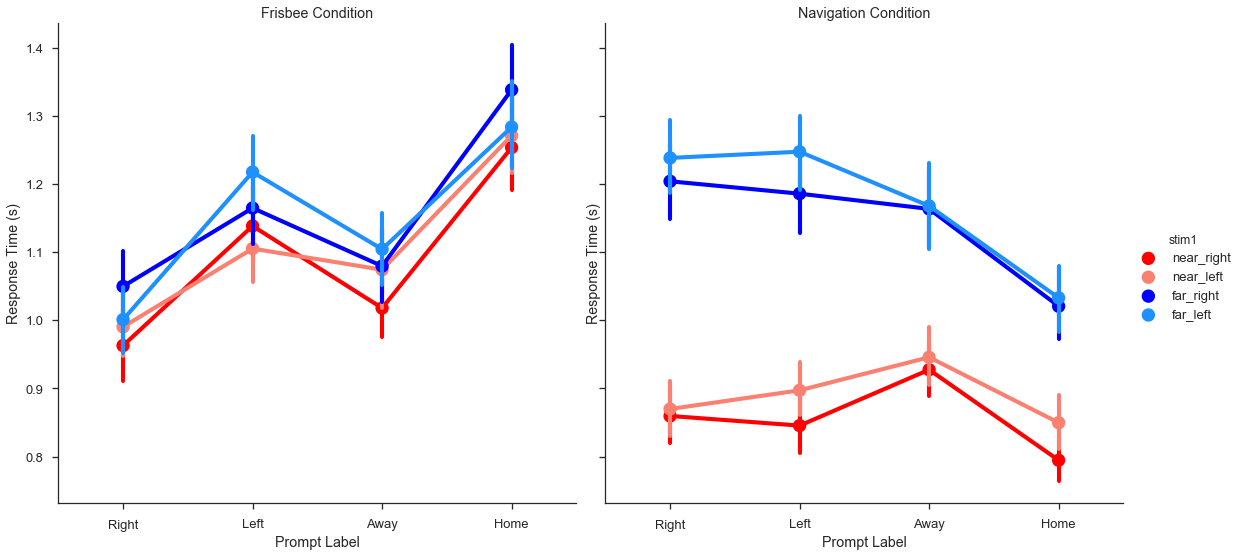

In [35]:
# Line Graphs
sns.set_style('ticks')
sns.set_context('talk')
ax1 = sns.factorplot(x = "promptType", y = "Trials_responsert", data = dataForPlot, hue = "stimLoc",palette=['red','blue'], 
                     kind = "point", size = 8,col='condition')
ax1.set(xlabel='Prompt Label', ylabel='Response Time (s)')
ax1.set_titles("{col_name} Condition")

ax2 = sns.factorplot(x = "prompt1", y = "Trials_responsert", data = dataForPlot, hue = "stim1", palette=['red','salmon','blue','dodgerblue'],
                    kind = "point", size = 8,col='condition', order=['Right','Left','Away','Home'], hue_order=['near_right','near_left','far_right','far_left'])

ax2.set(xlabel='Prompt Label', ylabel='Response Time (s)')
ax2.set_titles("{col_name} Condition")

plt.show()

# Scatter plots, correlation between Relative and Absolute

Is there a correlation between relative and absolute preference across frisbee and navigation?

We plot the scatter with and without outliers. To see outlier detection, [go here](#bivariate_outliers)


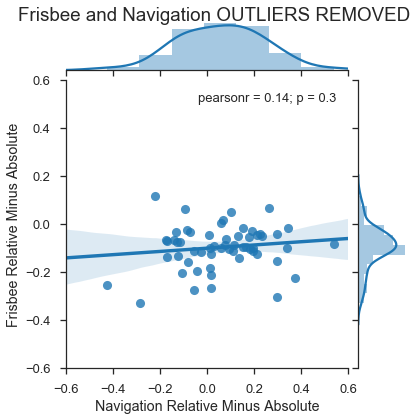

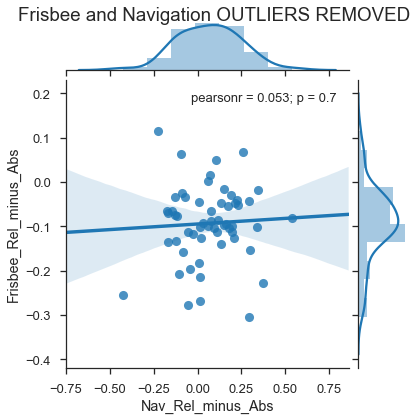

In [36]:
#Scatter plots

ax1 = sns.jointplot(pivoted['Nav_Rel_minus_Abs'], pivoted['Frisbee_Rel_minus_Abs'], kind="reg",size = 6)
ax1.set_axis_labels('Navigation Relative Minus Absolute', 'Frisbee Relative Minus Absolute')
plt.xlim(-.6,.6)
plt.ylim(-.6,.6)
ax1.fig.suptitle('Frisbee and Navigation OUTLIERS REMOVED')

outliersBetween = ['52817250']
noOutliersBetween = pivoted[~pivoted.participant.isin(outliersBetween)]
ax2 = sns.jointplot(noOutliersBetween['Nav_Rel_minus_Abs'], noOutliersBetween['Frisbee_Rel_minus_Abs'], kind="reg",size = 6)
ax2.fig.suptitle('Frisbee and Navigation OUTLIERS REMOVED')


plt.show()


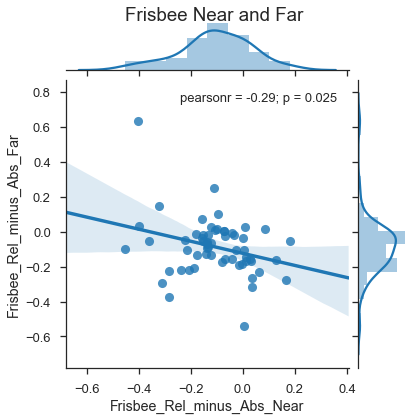

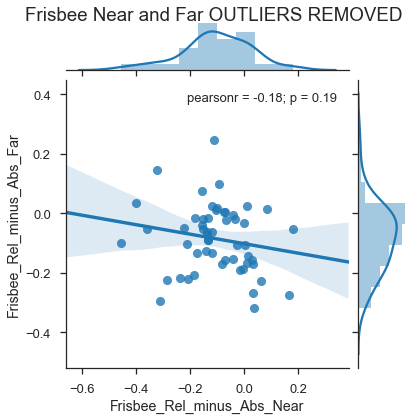

In [37]:
# Frisbee near and far

ax3 = sns.jointplot(pivoted['Frisbee_Rel_minus_Abs_Near'], pivoted['Frisbee_Rel_minus_Abs_Far'], kind="reg", size =6)
ax3.fig.suptitle('Frisbee Near and Far')

outliersFriz = ['44376975','99990726','26044874','52817250'] # from influence plot, below.
noOutliersFriz = pivoted[~pivoted.participant.isin(outliersFriz)]
ax4 = sns.jointplot(noOutliersFriz['Frisbee_Rel_minus_Abs_Near'], noOutliersFriz['Frisbee_Rel_minus_Abs_Far'], kind="reg", size =6)
ax4.fig.suptitle('Frisbee Near and Far OUTLIERS REMOVED')

plt.show()


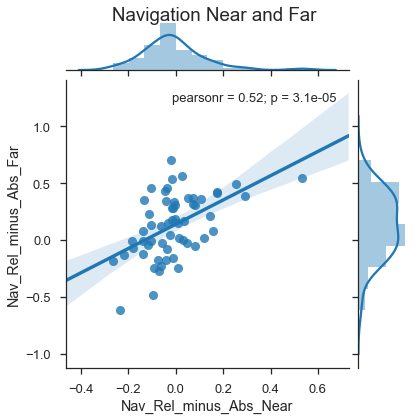

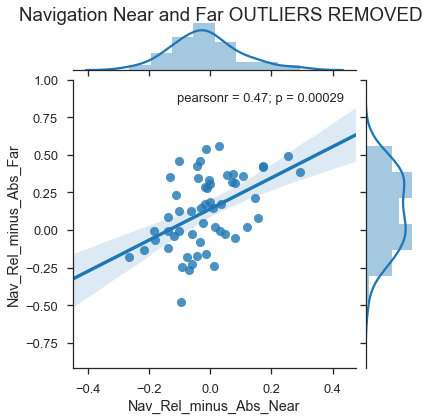

In [38]:
# Navigation near and far
ax5 = sns.jointplot(pivoted['Nav_Rel_minus_Abs_Near'], pivoted['Nav_Rel_minus_Abs_Far'], kind="reg", size =6)
ax5.fig.suptitle('Navigation Near and Far')

outliersNav = ['61216562','64824344','58839785'] # from influence plot, below.
noOutliersNav = pivoted[~pivoted.participant.isin(outliersNav)]
ax6 = sns.jointplot(noOutliersNav['Nav_Rel_minus_Abs_Near'], noOutliersNav['Nav_Rel_minus_Abs_Far'], kind="reg", size =6)
ax6.fig.suptitle('Navigation Near and Far OUTLIERS REMOVED')

plt.show()

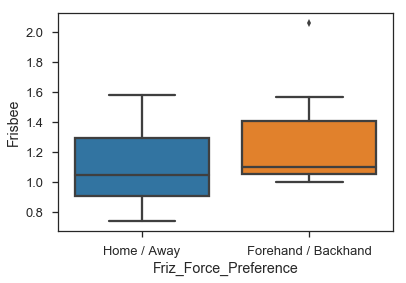

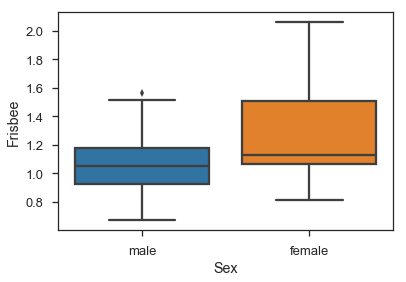

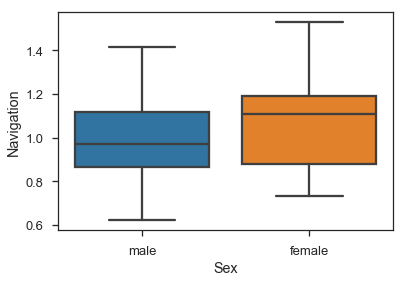

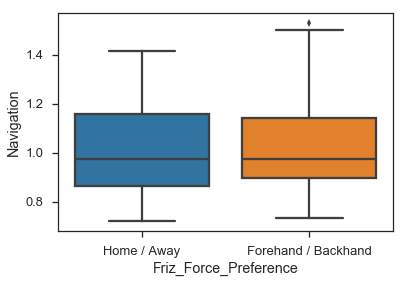

In [41]:

plt.figure()
ax6 = sns.boxplot(data=merged,x='Friz_Force_Preference',y="Frisbee")
plt.figure()
ax7 = sns.boxplot(data=merged,x='Sex',y="Frisbee")
plt.figure()
ax8 = sns.boxplot(data=merged,x='Sex',y="Navigation")
plt.figure()
ax9 = sns.boxplot(data=merged,x='Friz_Force_Preference',y="Navigation")



# Outlier Detection
<a id='bivariate_outliers'></a>

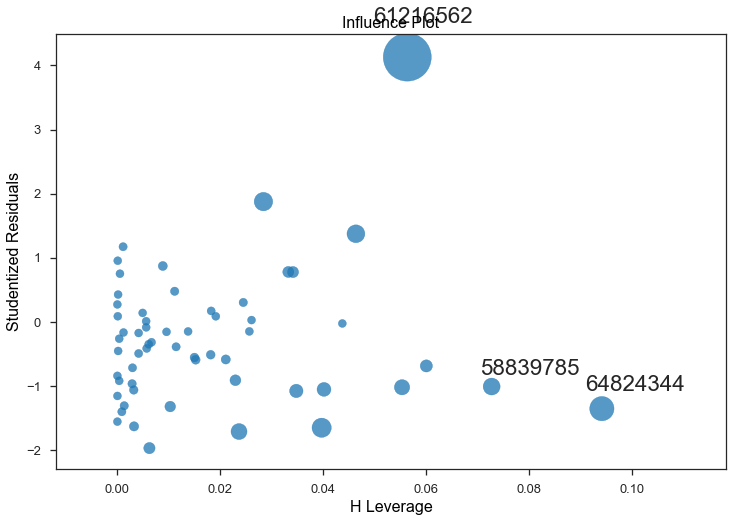

In [40]:
#Plot influence graph of outliers

fig,ax = plt.subplots(figsize=(12,8))
lm = sm.OLS(pivoted['Nav_Rel_minus_Abs_Near'], pivoted['Nav_Rel_minus_Abs_Far']).fit()
fig = sm.graphics.influence_plot(lm,alpha=0.05,ax=ax,criterion="cooks")
